In [17]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2grey

import skimage.io as io
import skimage.util as u

from scipy.ndimage import binary_fill_holes
from skimage.morphology import disk, ball, binary_opening, binary_erosion
from skimage.filters import threshold_minimum
from skimage.filters import threshold_otsu, median, gaussian, threshold_local
from skimage.filters.rank import tophat
from skimage import measure
import time

In [18]:
def plot_large(arr, x, y):
    figure = plt.figure(figsize=(x,y))
    ax = figure.add_subplot(111)
    ax.imshow(arr, cmap='gray')


def get_unimodal_threshold(input_image):
    """Determines optimal unimodal threshold

    https://users.cs.cf.ac.uk/Paul.Rosin/resources/papers/unimodal2.pdf
    https://www.mathworks.com/matlabcentral/fileexchange/45443-rosin-thresholding

    :param np.array input_image: generate mask for this image
    :return float best_threshold: optimal lower threshold for the foreground
     hist
    """

    hist_counts, bin_edges = np.histogram(
        input_image,
        bins=256,
        range=(input_image.min(), np.percentile(input_image, 99.5))
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # assuming that background has the max count
    max_idx = np.argmax(hist_counts)
    int_with_max_count = bin_centers[max_idx]
    p1 = [int_with_max_count, hist_counts[max_idx]]

    # find last non-empty bin
    pos_counts_idx = np.where(hist_counts > 0)[0]
    last_binedge = pos_counts_idx[-1]
    p2 = [bin_centers[last_binedge], hist_counts[last_binedge]]

    best_threshold = -np.inf
    max_dist = -np.inf
    for idx in range(max_idx, last_binedge, 1):
        x0 = bin_centers[idx]
        y0 = hist_counts[idx]
        a = [p1[0] - p2[0], p1[1] - p2[1]]
        b = [x0 - p2[0], y0 - p2[1]]
        cross_ab = a[0] * b[1] - b[0] * a[1]
        per_dist = np.linalg.norm(cross_ab) / np.linalg.norm(a)
        if per_dist > max_dist:
            best_threshold = x0
            max_dist = per_dist
    assert best_threshold > -np.inf, 'Error in unimodal thresholding'
    return best_threshold


def create_unimodal_mask(input_image, str_elem_size=3):
    """Create a mask with unimodal thresholding and morphological operations

    unimodal thresholding seems to oversegment, erode it by a fraction

    :param np.array input_image: generate masks from this image
    :param int str_elem_size: size of the structuring element. typically 3, 5
    :return: mask of input_image, np.array
    """

    if np.min(input_image) == np.max(input_image):
        thr = np.unique(input_image)
    else:
        thr = get_unimodal_threshold(input_image)
    if len(input_image.shape) == 2:
        str_elem = disk(str_elem_size)
    else:
        str_elem = ball(str_elem_size)
    # remove small objects in mask
    thr_image = binary_opening(input_image > thr, str_elem)
    mask = binary_erosion(thr_image, str_elem)
    return mask

def create_otsu_mask(input_image, str_elem_size=3, thr=None):
    """Create a binary mask using morphological operations

    Opening removes small objects in the foreground.

    :param np.array input_image: generate masks from this image
    :param int str_elem_size: size of the structuring element. typically 3, 5
    :return: mask of input_image, np.array
    """

    if thr is None:
        if np.min(input_image) == np.max(input_image):
            thr = np.unique(input_image)
        else:
            thr = threshold_otsu(input_image, nbins=512)
    if len(input_image.shape) == 2:
        str_elem = disk(str_elem_size)
    else:
        str_elem = ball(str_elem_size)
    # remove small objects in mask
    thr_image = binary_opening(input_image > thr, str_elem)
    mask = binary_fill_holes(thr_image)
    return mask

In [19]:
# path_to_cells = '../Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera'
path_to_cells = '/Users/bryant.chhun/PycharmProjects/array-imager/Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera'
images = [file for file in os.listdir(path_to_cells) if '.png' in file]

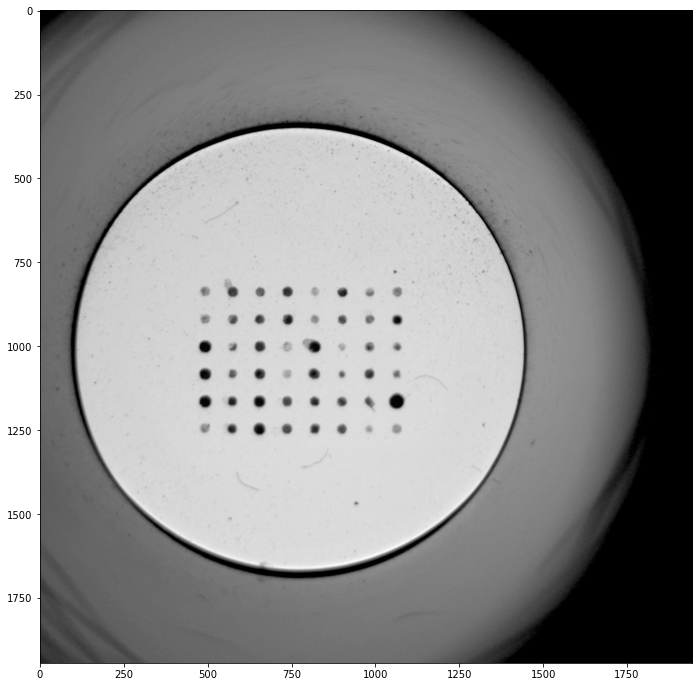

In [20]:
im = io.imread(path_to_cells+os.sep+'A1.png')

image = rgb2grey(im)
plot_large(image, 12,12)

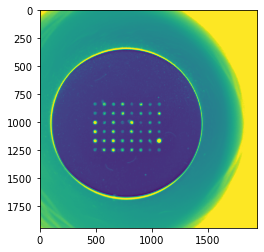

In [22]:
inv = u.invert(image)
plt.imshow(inv)

thresh = threshold_minimum(inv)
thresh

well_mask = create_otsu_mask(image, str_elem_size=10)

labels = measure.label(well_mask)
props = measure.regionprops(labels)

well_cent = [int(x) for x in props[0].centroid]
well_radi = int(props[0].minor_axis_length/2/np.sqrt(2))

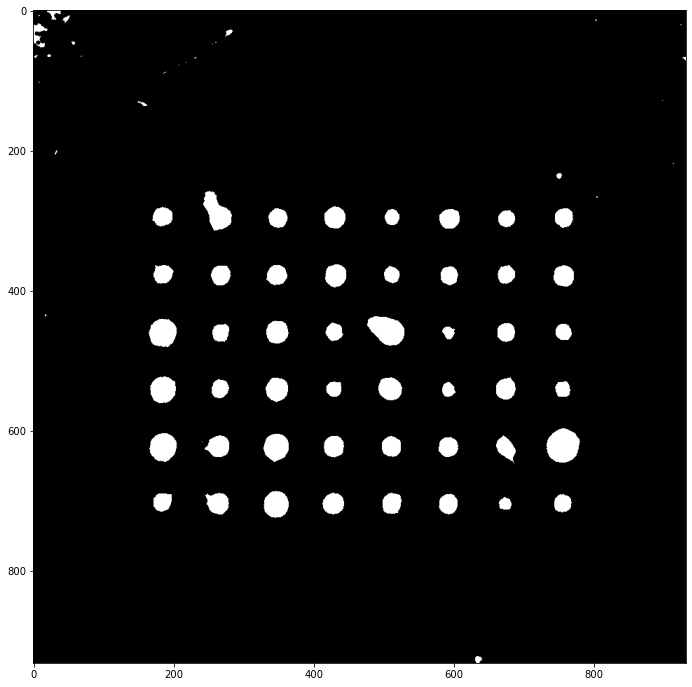

In [31]:
im_inv_crop = inv[well_cent[0]-well_radi:well_cent[0]+well_radi,\
             well_cent[1]-well_radi:well_cent[1]+well_radi]

crop = image[well_cent[0]-well_radi:well_cent[0]+well_radi,\
             well_cent[1]-well_radi:well_cent[1]+well_radi]

spot_mask = create_unimodal_mask(im_inv_crop)
plot_large(spot_mask, 12, 12)

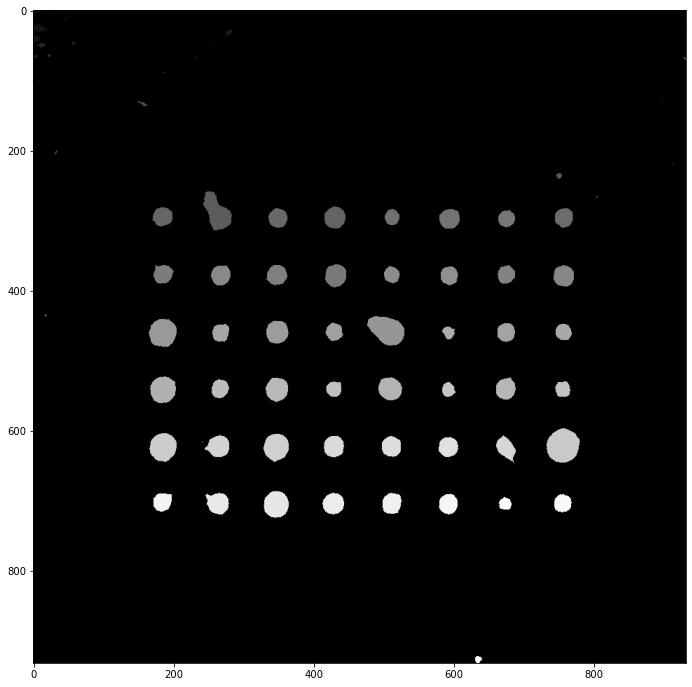

In [29]:
labels = measure.label(spot_mask)
plot_large(labels, 12, 12)

In [57]:
props = measure.regionprops(labels, intensity_image=crop)
# props = [p for p in props if p.eccentricity <0.5]
# props = [p for p in props if p.area > 150]
len(props)

45

In [173]:
# filter centroid map
props = [p for p in props if p.area > 200]
props = [p for p in props if p.eccentricity < 0.5]
len(props)

45

In [177]:
"""
Creates a dictionary whose keys are (centroid_x, centroid_y) scaled to int
    and whose values are region_prop objects
"""
(x, y) = spot_mask.shape
c = 0
# find minx, miny to "zero center" the array
minx = x
miny = y
# find maxx, maxy to scale to array index values
maxx = 0
maxy = 0
for prop in props:
    if prop.area > 100:
        if prop.centroid[0] < minx:
            minx = prop.centroid[0]
        if prop.centroid[1] < miny:
            miny = prop.centroid[1]
        if prop.centroid[0] > maxx:
            maxx = prop.centroid[0]
        if prop.centroid[1] > maxy:
            maxy = prop.centroid[1]
        
print((minx, miny, maxx, maxy))

# use centroid positions to map prop to array index values
chk_list = []
cent_map = {}
for prop in props:
    if prop.area > 100:
        cx, cy = prop.centroid
        csx = cx-minx
        csy = cy-miny
        
        smaxx = maxx-minx
        smaxy = maxy-miny
        
        # "zero center"
        # scale by number of pixels
        # mutiply by number of wells
        norm_cent_x = int(round(5*(csx/smaxx)))
        norm_cent_y = int(round(7*(csy/smaxy)))
        
        print(f"\ncentroid = {prop.centroid}\n\tnorm_cent = {norm_cent_x, norm_cent_y}")
        
        chk_list.append((norm_cent_x, norm_cent_y))
        cent_map[(norm_cent_x, norm_cent_y)] = prop
        c+=1
print(c)

# check if all keys (coordinates) are unique.
if len(chk_list) != len(set(chk_list)):
    print("ERROR, DUPLICATE ENTRIES")

(294.54545454545456, 184.3885918003565, 705.2198515769944, 757.430823117338)

centroid = (295.86418109187747, 430.5006657789614)
	norm_cent = (0, 3)

centroid = (294.54545454545456, 184.6297520661157)
	norm_cent = (0, 0)

centroid = (296.53061224489795, 349.2312925170068)
	norm_cent = (0, 2)

centroid = (295.9316987740806, 757.430823117338)
	norm_cent = (0, 7)

centroid = (295.25935828877004, 512.072192513369)
	norm_cent = (0, 4)

centroid = (297.487915407855, 594.1918429003022)
	norm_cent = (0, 5)

centroid = (297.3793859649123, 675.5043859649123)
	norm_cent = (0, 6)

centroid = (378.54140127388536, 431.66369426751595)
	norm_cent = (1, 3)

centroid = (376.46440677966103, 185.13220338983052)
	norm_cent = (1, 0)

centroid = (377.84954407294833, 347.63981762917933)
	norm_cent = (1, 2)

centroid = (377.1620553359684, 674.9782608695652)
	norm_cent = (1, 6)

centroid = (379.17622377622376, 757.1958041958042)
	norm_cent = (1, 7)

centroid = (378.1023622047244, 267.66771653543304)
	norm_cent 

In [183]:
# assign props to array
props_arr = np.empty(shape=(6, 8), dtype=object)
for key, value in cent_map.items():
    props_arr[key[0],key[1]] = value


In [58]:
(x, y) = spot_mask.shape
c = 0
# find minx, miny to "zero center" the array
minx = x
miny = y
# find maxx, maxy to scale to array index values
maxx = 0
maxy = 0
for prop in props:
    if prop.area > 100:
        if prop.centroid[0] < minx:
            minx = prop.centroid[0]
        if prop.centroid[1] < miny:
            miny = prop.centroid[1]
        if prop.centroid[0] > maxx:
            maxx = prop.centroid[0]
        if prop.centroid[1] > maxy:
            maxy = prop.centroid[1]
        
print((minx, miny, maxx, maxy))

(294.54545454545456, 184.3885918003565, 705.2198515769944, 757.430823117338)


In [60]:
x_vals = []
y_vals = []
for prop in props:
    x_vals.append(prop.centroid[0])
    y_vals.append(prop.centroid[1])

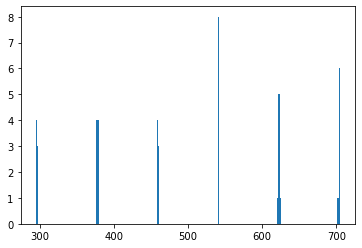

In [68]:
a = plt.hist(x_vals, bins=256)


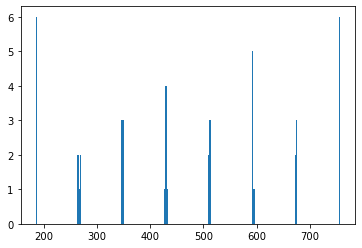

In [69]:
b = plt.hist(y_vals, bins=256)

In [100]:
# find the largest bin corresponding to minimum x
# r = bins / rows
r = int(256 / 6)
hist_min_x = a[0][:r].argmax()

# find the largest bin corresponding to maximum x
hist_max_x = a[0][-r:].argmax()
(hist_min_x, hist_max_x)

(0, 41)

In [104]:
hist_min_pix = a[1][:r][hist_min_x]

hist_max_pix = a[1][-r:][hist_max_x]
(hist_min_pix, hist_max_pix)

(294.54545454545456, 705.2198515769944)

In [135]:
"""
Full procedure using numpy

The output is almost always going to be the min/max bounds of x_vals and y_vals

"""
x_vals = []
y_vals = []
for prop in props:
    x_vals.append(prop.centroid[0])
    y_vals.append(prop.centroid[1])
    
bins_x = int((max(x_vals)-min(x_vals)) / 2)
bins_y = int((max(x_vals)-min(x_vals)) / 2)

hx = np.histogram(x_vals, bins=bins_x)
hy = np.histogram(y_vals, bins=bins_y)

rx = int(bins_x / 6)
ry = int(bins_y / 8)

hist_min_x = hx[0][:rx].argmax()
hist_max_x = hx[0][-rx:].argmax()

hist_min_y = hy[0][:ry].argmax()
hist_max_y = hy[0][-ry:].argmax()

(hist_min_x, hist_max_x, hist_min_y, hist_max_y, rx, ry)

(0, 33, 0, 24, 34, 25)

In [137]:
# extract the pixel coordinates of the far boundaries (centroid)

hist_min_x_pix = ax[1][:rx][hist_min_x]
hist_max_x_pix = ax[1][-rx:][hist_max_x]

hist_min_y_pix = ay[1][:ry][hist_min_y]
hist_max_y_pix = ay[1][-ry:][hist_min_x]

(hist_min_x_pix, hist_max_x_pix, hist_min_y_pix, hist_max_y_pix)

(294.54545454545456, 705.2198515769944, 184.3885918003565, 690.3429521338866)

In [146]:
# find the average bbox size
bbox_area = [a.bbox_area for a in props]
area = np.sum(bbox_area)/len(bbox_area)
side = int(np.sqrt(area))


29

In [214]:
# build an even grid of square masks around the expected spot position
delta_x = hist_max_x_pix - hist_min_x_pix
delta_y = hist_max_y_pix - hist_min_y_pix

space_x = delta_x / 6
space_y = delta_y / 8

blank = np.ones((side, side))
target = np.zeros((spot_mask.shape))

# center position of the origin
origin = (hist_min_x_pix, hist_min_y_pix)
for row in range(6):
    for col in range(8):
        center_x = origin[0]+row*space_x
        center_y = origin[1]+col*space_y
        print(center_x, center_y)
        target[int(center_x-side/2) : int(center_x+side/2), int(center_y-side/2):int(center_y+side/2)] = blank

68.44573283858998
63.24429504169126
294.54545454545456 184.3885918003565
294.54545454545456 247.63288684204775
294.54545454545456 310.877181883739
294.54545454545456 374.1214769254303
294.54545454545456 437.36577196712153
294.54545454545456 500.6100670088128
294.54545454545456 563.854362050504
294.54545454545456 627.0986570921953
362.99118738404457 184.3885918003565
362.99118738404457 247.63288684204775
362.99118738404457 310.877181883739
362.99118738404457 374.1214769254303
362.99118738404457 437.36577196712153
362.99118738404457 500.6100670088128
362.99118738404457 563.854362050504
362.99118738404457 627.0986570921953
431.4369202226345 184.3885918003565
431.4369202226345 247.63288684204775
431.4369202226345 310.877181883739
431.4369202226345 374.1214769254303
431.4369202226345 437.36577196712153
431.4369202226345 500.6100670088128
431.4369202226345 563.854362050504
431.4369202226345 627.0986570921953
499.88265306122446 184.3885918003565
499.88265306122446 247.63288684204775
499.88265

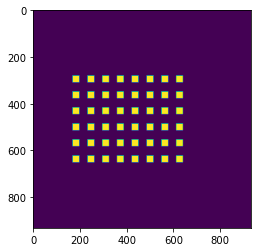

In [167]:
plt.imshow(target)

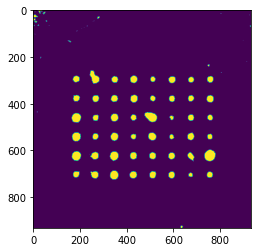

In [168]:
plt.imshow(spot_mask)

In [190]:
props_arr[0][7].centroid
"""
The above approach seems to have not correctly estimated the max_y pix
    the "hist_max_y_pix" is == 690.34, while in this cell we can see that
    the fiducial (row=0, col=7) is at 757
"""

(295.9316987740806, 757.430823117338)

In [197]:
"""
Below we will try another approach.  Here we'll simply use the fiducial coordinates from earlier region props approach
the caveat here is:
1) the fiducials must be identified (no junk around it to obscure the measurement)
2) we have to do the full process (spot_mask -> label/region_prop -> filter -> centroid map -> assign to array)
"""

fiduc_1 = props_arr[0][0]
fiduc_2 = props_arr[0][7]
fiduc_3 = props_arr[5][0]
fiduc_4 = props_arr[5][7]

In [201]:
fiduc_1.centroid, fiduc_2.centroid, fiduc_3.centroid, fiduc_4.centroid

((294.54545454545456, 184.6297520661157),
 (295.9316987740806, 757.430823117338),
 (701.6773618538324, 184.3885918003565),
 (703.6379647749511, 755.5518590998043))

In [209]:
x_min = (fiduc_1.centroid[0] + fiduc_2.centroid[0])/2
y_min = (fiduc_1.centroid[1] + fiduc_3.centroid[1])/2

x_max = (fiduc_3.centroid[0] + fiduc_4.centroid[0])/2
y_max = (fiduc_2.centroid[1] + fiduc_4.centroid[1])/2

x_min, y_min, x_max, y_max

(295.23857665976755, 184.5091719332361, 702.6576633143918, 756.4913411085712)

In [225]:
space_x = (x_max - x_min)/5
space_y = (y_max - y_min)/7

blank = np.ones((side, side))
target = np.zeros((spot_mask.shape))

# center position of the origin
origin = (hist_min_x_pix, hist_min_y_pix)
for row in range(6):
    for col in range(8):
        center_x = origin[0]+row*space_x
        center_y = origin[1]+col*space_y
        target[int(center_x-side/2) : int(center_x+side/2), int(center_y-side/2):int(center_y+side/2)] = blank

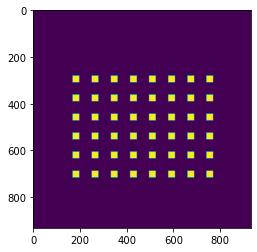

In [226]:
plt.imshow(target)

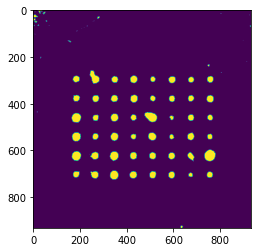

In [220]:
plt.imshow(spot_mask)

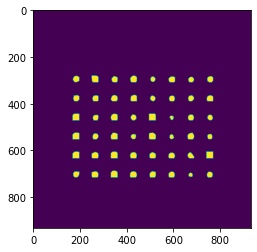

In [242]:
a = target*spot_mask
plt.imshow(a)

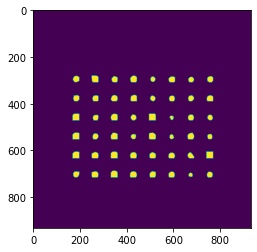